In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import numpy as np
import random
import pickle 

def scrape_goodreads_ratings(user_id, max_pages=10):
    """
    Scrape a user's star ratings from Goodreads.
    
    Args:
    - user_id (str): Goodreads user ID or profile suffix.
    - max_pages (int): Maximum number of pages to scrape (each page contains ~30 books).
    
    Returns:
    - pd.DataFrame: A DataFrame containing book titles and ratings.
    """
    base_url = f"https://www.goodreads.com/review/list/{user_id}?shelf=read"
    headers = {"User-Agent": "Mozilla/5.0"}
    books = []

    for page in range(1, max_pages + 1):
        url = f"{base_url}&page={page}"
        response = requests.get(url, headers=headers)
        
        if response.status_code != 200:
            print(f"Failed to fetch page {page}. Status code: {response.status_code}")
            break

        soup = BeautifulSoup(response.content, "html.parser")
        
        # Find all book entries in the table
        rows = soup.find_all("tr", class_="bookalike review")
        if not rows:
            print("No more data found.")
            break

        for row in rows:
            try:
                title = row.find("td", class_="field title").a.text.strip()
                rating_element = row.find("td", class_="field rating")
                rating = rating_element.find("span", class_="staticStars").get("title", "No rating")
                stars = map_rating(rating)
                books.append({"Title": title, "Rating": stars, "User_id": user_id})
#                 print(title, rating, stars)
            except AttributeError:
                # Handle rows with missing data
                continue

        print(f"Page {page} scraped successfully.")
        time.sleep(random.uniform(1, 5))  # Be kind to the server and avoid being blocked

    # Return data as a pandas DataFrame
    return pd.DataFrame(books)



In [2]:
def map_rating(phrase):
    rating_map = {
        "liked it": 3,
        "really liked it": 4,
        "it was ok": 2, 
        "it was amazing": 5, 
        "did not like it": 1,
    }
    
    return rating_map.get(phrase, "Invalid rating")  # Default to "Invalid rating" if the phrase isn't in the dictionary


In [3]:
# if __name__ == "__main__":
# #     user_id = "6688207"  # Replace with the Goodreads user ID or profile suffix
# #     for user_id in tqdm(['30181442', '75009563', '11345366', '110912303', '113964939', '11215896', '53701594', '4622890', '93628736', '176180116']):
# #     for user_id in tqdm(['2974095', '4622890', '28953843', '16174645', '4159922', '4125660', '54886546', '16912659', '260116', '4685500', '21865425']):
# #     for user_id in tqdm(['53701594', '27709782', '7566229', '16652861', '30817744', '56259255', '4125660', '60964126', 
# #                          '176167767', '28510930', '1029975', '131020767', '28862120', '88713906', '160141433', '41097916', 
# #                          '20809863', '69519261', '24017481', '7376365', '75941333', '13571407', '106618742', '17792052',
# #                          '3534528', '130656897', '7474475', '4125412', '6336365', '6026811', '3438047']):
#     for user_id in ['169695556']:
#         print("User_id = ", user_id)
#         max_pages = 30  # Adjust based on expected data
#         ratings_data = scrape_goodreads_ratings(user_id, max_pages)

#         if not ratings_data.empty:
# #             print(ratings_data.head())
# #             ratings_data.to_csv("goodreads_ratings.csv", index=False)
#             ratings_data.to_csv('goodreads_ratings.csv', mode='a', header=False, index=False)
#             print("Data saved to goodreads_ratings.csv.")
#         else:
#             print("No data retrieved.")


In [4]:
df = pd.read_csv('goodreads_ratings.csv')
print(df.shape)
df = df.drop_duplicates()
print(df.shape)
# Print the entire DataFrame
print(df)

duplicate_count = df['Title'].duplicated().sum()
# print("Number of books with at least two people rating it:", duplicate_count)
duplicate_counts_per_value = df['Title'].value_counts()
print(duplicate_counts_per_value)
print("Number of unique books: ", df['Title'].nunique())
num_users = df['User_id'].nunique()
user_ids = list(df['User_id'].unique())
print("number of users is: ", num_users)
# print("user_ids = ", user_ids)

(283220, 3)
(271813, 3)
                                                    Title Rating    User_id
0                                       I Am Watching You      3  169695558
1       Three to Get Deadly\n        (Stephanie Plum, #3)      3  169695558
2       Before the Coffee Gets Cold\n        (Before t...      4  169695558
3       Dark Sacred Night\n        (Renée Ballard, #2;...      4  169695558
4         Two for the Dough\n        (Stephanie Plum, #2)      4  169695558
...                                                   ...    ...        ...
283215                                    Five Feet Apart      4  133546120
283216         Me Before You\n        (Me Before You, #1)      5  133546120
283217                                     Eleanor & Park      4  133546120
283218  Anna and the French Kiss\n        (Anna and th...      5  133546120
283219                             The Fault in Our Stars      4  133546120

[271813 rows x 3 columns]
Harry Potter and the Sorcerer's Stone

In [5]:
df['Series'] = df['Title'].str.contains('\n', case=False)
df['First'] = df['Title'].str.contains(r"#1\)", case=False) & df['Series']
# active_rows = df[df['Active']]
# print(df[df['First']])

df['Suggest'] = (df['Series'] == False) | (df['First'] == True)
print(df)

df.to_csv("goodreads_ratings_series.csv", index=False)

# with open("suggest.pkl", "wb") as file:
#     pickle.dump(list(df['Suggest']), file)

                                                    Title Rating    User_id  \
0                                       I Am Watching You      3  169695558   
1       Three to Get Deadly\n        (Stephanie Plum, #3)      3  169695558   
2       Before the Coffee Gets Cold\n        (Before t...      4  169695558   
3       Dark Sacred Night\n        (Renée Ballard, #2;...      4  169695558   
4         Two for the Dough\n        (Stephanie Plum, #2)      4  169695558   
...                                                   ...    ...        ...   
283215                                    Five Feet Apart      4  133546120   
283216         Me Before You\n        (Me Before You, #1)      5  133546120   
283217                                     Eleanor & Park      4  133546120   
283218  Anna and the French Kiss\n        (Anna and th...      5  133546120   
283219                             The Fault in Our Stars      4  133546120   

       Series  First  Suggest  
0       False  Fals

In [6]:
# Get a list of top titles in order
top_titles = duplicate_counts_per_value.index.tolist()
top_100 = top_titles[:1000]

for title in top_100:
    print(title)
    
# with open("top_100.pkl", "wb") as file:
#     pickle.dump(top_100, file)

Harry Potter and the Sorcerer's Stone
        (Harry Potter, #1)
To Kill a Mockingbird
The Hunger Games
        (The Hunger Games, #1)
Twilight
        (The Twilight Saga, #1)
The Great Gatsby
The Catcher in the Rye
1984
Animal Farm
Harry Potter and the Prisoner of Azkaban
        (Harry Potter, #3)
Harry Potter and the Chamber of Secrets
        (Harry Potter, #2)
The Hobbit, or There and Back Again
        (The Lord of the Rings, #0)
Pride and Prejudice
Harry Potter and the Deathly Hallows
        (Harry Potter, #7)
Lord of the Flies
Harry Potter and the Goblet of Fire
        (Harry Potter, #4)
The Kite Runner
Harry Potter and the Half-Blood Prince
        (Harry Potter, #6)
Romeo and Juliet
The da Vinci Code
        (Robert Langdon, #2)
Catching Fire
        (The Hunger Games, #2)
Harry Potter and the Order of the Phoenix
        (Harry Potter, #5)
The Diary of a Young Girl
Mockingjay
        (The Hunger Games, #3)
The Lovely Bones
Of Mice and Men
The Help
The Alchemist
The Girl wi

In [7]:
# threshold = 10#num_users * 0.1
# pop_titles = list(duplicate_counts_per_value[duplicate_counts_per_value > threshold].index)
# my_titles = df.loc[df["User_id"] == 169695558, "Title"].tolist()
# # print(my_titles)

# print("pop titles len = ", len(pop_titles))
# # print(pop_titles)
# print("my titles len = ", len(my_titles))
# titles = list(set(pop_titles))# + my_titles))

#load the titles, 
with open("titles.pkl", "rb") as file:
    titles = pickle.load(file)
    
#If I need to filter out any titles, like box sets
# # print(titles)
# print("titles = ", len(titles))
# filtered_titles = [title for title in titles if "holy bible" not in title.lower()]
# print("filtered_titles = ", len(filtered_titles))
# # print(filtered_titles)
# with open("titles.pkl", "wb") as file:
#     pickle.dump(filtered_titles, file)


# #remove Harry Potter titles:
# titles = [s for s in titles if "Harry Potter" not in s]

num_titles = len(titles)


# print(titles)
# print(titles)
print("num_titles =", num_titles)

# ratings = np.full((num_users, num_titles), None)
ratings = np.zeros((num_users, num_titles))

for index, row in df.iterrows():
    if row['Title'] in titles:
        try:
            ratings[user_ids.index(row['User_id']), titles.index(row["Title"])] = int(row["Rating"])
#             print("found ", row["Title"])
        except:
            pass
        
print("ratings size = ", ratings.shape)
ratings = ratings[~np.all(ratings == 0, axis=1)]
print("ratings size = ", ratings.shape)
# Save the list to a file
# with open("titles.pkl", "wb") as file:
#     pickle.dump(titles, file)
    
    

# df['Series'] = df['Title'].str.contains('\n', case=False)
# df['First'] = df['Title'].str.contains('#1', case=False) & df['Series']
# # active_rows = df[df['Active']]
# # print(df[df['First']])

# df['Suggest'] = (df['Series'] == False) | (df['First'] == True)
# print(df)

# df.to_csv("goodreads_ratings_series.csv", index=False)



num_titles = 3023
ratings size =  (3514, 3023)
ratings size =  (2374, 3023)


In [8]:
# #make suggest list 
# suggest = [True] * len(titles)
# for i, this in enumerate(titles):
#     if '\n' in this:
#         if "#1" not in this:
#             suggest[i] = False
        
# # for i in range(len(suggest)):        
# #     print(titles[i], suggest[i])
    
# with open("suggest.pkl", "wb") as file:
#     pickle.dump(suggest, file)

In [9]:
ratings_df = pd.DataFrame(ratings)
print(ratings_df.shape)
#delete users that don't have any of these ratings
# ratings_df = ratings_df.loc[~(ratings_df == 0).all(axis=1)]
ratings_df = ratings_df.loc[(ratings_df != 0).sum(axis=1) >= 5] #need at least 4 entries to stay
print(ratings_df.shape)

# Calculate percentage of non-zero elements
percentage_nonzero = (np.count_nonzero(ratings_df) / ratings_df.size) * 100
print("percentage_nonzero =", round(percentage_nonzero, 1), '%')

# Save the list to a file
with open("ratings_df.pkl", "wb") as file:
    pickle.dump(ratings_df, file)

(2374, 3023)
(1742, 3023)
percentage_nonzero = 1.6 %


Text(0, 0.5, 'Readers')

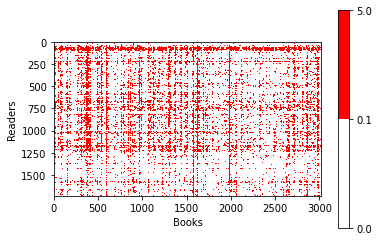

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap with white, yellow, and red
cmap = mcolors.ListedColormap(['white', 'red'])
bounds = [0, 0.1, 5]  # Define ranges: 0 (white), 0.1-0.5 (yellow), 0.5-1 (red)
norm = mcolors.BoundaryNorm(bounds, len(cmap.colors))

plt.imshow(ratings_df, cmap=cmap, norm=norm)
plt.colorbar()
plt.xlabel("Books")
plt.ylabel("Readers")

Text(0, 0.5, 'Number of books')

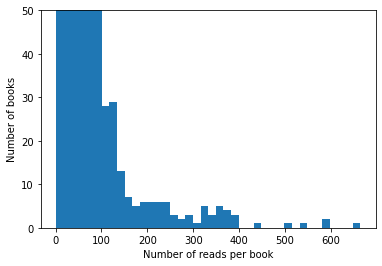

In [11]:
plt.hist(duplicate_counts_per_value, bins = 40)
plt.ylim([0,50])
plt.xlabel('Number of reads per book')
plt.ylabel("Number of books")
# print(duplicate_counts_per_value)

Text(0, 0.5, 'Number of users')

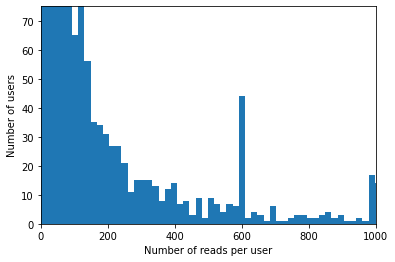

In [12]:
duplicate_counts_per_user = df['User_id'].value_counts()
plt.hist(duplicate_counts_per_user, bins = 100)
plt.ylim([0,75])
plt.xlim([0,1000])
plt.xlabel('Number of reads per user')
plt.ylabel("Number of users")
# print(duplicate_counts_per_value)

5464046     1846
48727754    1000
5015868     1000
4776032     1000
2040319     1000
            ... 
83783370       1
83783364       1
83783362       1
4776126        1
9726962        1
Name: User_id, Length: 3514, dtype: int64
[ 2.06133849  5.87262275 21.66868537 36.91111071 33.48624268]


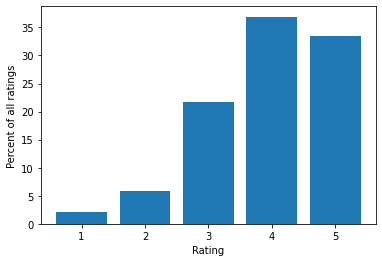

In [13]:
per_rating = df['Rating'].value_counts()
print(duplicate_counts_per_user)
# plt.hist(duplicate_counts_per_user)
# plt.ylim([0,75])
# plt.xlim([0,1000])
plt.xlabel('Rating')
plt.ylabel("Percent of all ratings")
# print(duplicate_counts_per_value)
per_rating_list = np.array([per_rating['1'], per_rating['2'], per_rating['3'], per_rating['4'], per_rating['5']])
total = per_rating_list.sum()
# plt.plot([1, 2, 3, 4, 5], [per_rating['1'], per_rating['2'], per_rating['3'], per_rating['4'], per_rating['5']])
plt.bar([1, 2, 3, 4, 5], per_rating_list / total * 100)#, color='skyblue')

print(per_rating_list / total * 100)